# Sampling, Bias, and Community Structure in Real Networks

## Part A — Sampling and Bias in Network Analysis (15 pts)

Goal: Investigate how different sampling methods can change the observed structure of a social network.

In [45]:
import networkx as nx
import random
from tabulate import tabulate
import matplotlib.pyplot as plt

In [2]:
G_fb = nx.read_edgelist("facebook_combined.txt", nodetype=int)

### A1 – Create Two Samples (6 pts)

In [ ]:
# 1. Random Sample – Randomly select 250 nodes.
nodes = random.sample(sorted(G_fb.nodes()), 250)
G_random = G_fb.subgraph(nodes).copy()

# 2. Ego-Centered Sample – Pick a node with degree > 50 and build its 1.5-degree ego network.
center = max(G_fb, key=lambda n: G_fb.degree(n))
G_ego = nx.ego_graph(G_fb, center, radius=1)
print(
    tabulate(
        [
            ["Random", G_random.number_of_nodes(), G_random.number_of_edges()],
            ["Ego", G_ego.number_of_nodes(), G_ego.number_of_edges()],
        ],
        headers=["Sample", "# Nodes", "# Edges"]
    )
)

Sample      # Nodes    # Edges
--------  ---------  ---------
Random          250        376
Ego            1046      27795


## A2 – Compute and Visualize Metrics (6 pts)

For each sample (`G_random`, `G_ego`):

- Compute Average Clustering Coefficient (C)
- Compute Average Shortest Path Length (L) (on largest component if needed)
- Find Maximum Degree (Max k)

### 1. Table of Metrics

In [ ]:
print(
    tabulate(
        [
            [
                "Random",
                round(nx.average_clustering(G_random), 2),
                round(
                    nx.average_shortest_path_length(
                        G_random.subgraph(
                            max(nx.connected_components(G_random), key=len)
                        )
                    ),
                    2,
                ),
                max(G_random.degree, key=lambda x: x[1])[1],
            ],
            [
                "Ego",
                round(nx.average_clustering(G_ego), 2),
                round(
                    nx.average_shortest_path_length(
                        G_ego.subgraph(
                            max(nx.connected_components(G_ego), key=len)
                        )
                    ),
                    2,
                ),
                max(G_ego.degree, key=lambda x: x[1])[1],
            ],
        ],
        headers=["Sample", "Avg Clustering (C)", "Avg Path (L)", "Max Degree"]
    )
)

Sample      Avg Clustering (C)    Avg Path (L)    Max Degree
--------  --------------------  --------------  ------------
Random                    0.35            1.93            14
Ego                       0.58            1.95          1045


### 2. Two degree distribution plots (log–log axes)

Each plot must include a title, axis labels (“Degree (k)” and “Count of Nodes”)

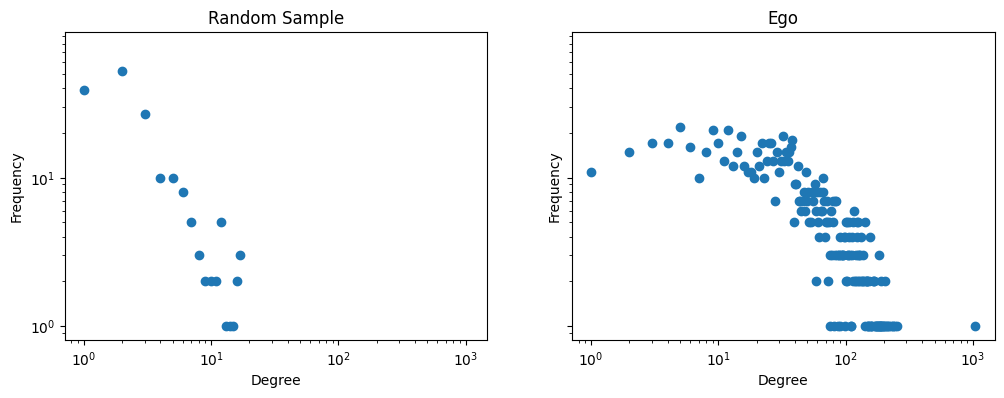

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)

axes[0].set_title("Random Sample")
axes[0].set_xlabel("Degree")
axes[0].set_ylabel("Frequency")
degree_freq = nx.degree_histogram(G_random)
degrees = range(len(degree_freq))
axes[0].loglog(degrees, degree_freq, "o")

axes[1].set_title("Ego")
axes[1].set_xlabel("Degree")
axes[1].set_ylabel("Frequency")
degree_freq = nx.degree_histogram(G_ego)
degrees = range(len(degree_freq))
axes[1].loglog(degrees, degree_freq, "o")
plt.show()

## A3 – Reflection (3 pts)

Write one paragraph **(5–7 complete sentences)** under the heading “**Part A Reflection.**”
Discuss:
- How the random and ego-centered samples differ in clustering and degree patterns
- What type of bias the ego-sampling method introduces
- What the differences imply about sampling in real network data

### Part A Reflection.

The random sample subgraph of the FB combined graph differ significantly from
the ego subgraph because the ego subgraph is directly selecting for the node 
with highest degree centrality. This skews both the number of nodes and number 
of edges because the ego node has an unsually high number of neighbors. Another 
sampling bias that is introduced when using the ego graph is that the degree 
distribution is pushed higher. We see that the random sample nicely follows the 
scale free trend, producing a strong linear relationship on a log-log plot. 
However, the degree distribution of the ego graph shows that there are more
nodes that have a relatively high degree. This is a result of social prestige 
and preferential attatchment. Popular nodes tend to stick by other popular nodes,
thus the ego graph of a popular node will have, on average, higher degrees. 

## Part B — Community Detection and Modularity (15 pts)

**Goal:** Identify and compare community structure across model networks and a real social network.

### B1 – Run Community Detection (8 pts)

Compute the following for each graph (ER, WS, BA, Facebook):
- Number of communities
- Modularity Q
- Size of largest community (number of nodes)
- Also include one **visualization** showing a few detected communities in different colors.

In [83]:
n = len(G_fb)
m = len(G_fb.edges)
G_er = nx.erdos_renyi_graph(n, (2*m)/(n*(n-1)))
G_ws = nx.watts_strogatz_graph(n, 10, 0.1)
G_ba = nx.barabasi_albert_graph(n, 2)

In [ ]:
headers = ["Network", "# Communities", "Modularity (Q)", "Largest Community Size"]
networks = {
    "ER": G_er,
    "WS": G_ws, 
    "BA": G_ba,
    "Facebook": G_fb,
}

tabs = []
for name, G in networks.items():
    tab = []
    tab.append(name)

    # Find communities
    communities = nx.community.greedy_modularity_communities(G)
    tab.append(len(communities))

    # Find modularity Q
    tab.append(nx.community.modularity(G, communities))

    # Find biggest community
    tab.append(max(len(community) for community in communities))

    tabs.append(tab)

print(tabulate(tabs, headers))

Network      # Communities    Modularity (Q)    Largest Community Size
---------  ---------------  ----------------  ------------------------
ER                       5          0.11962                       1497
WS                       5          0.702869                      1029
BA                      27          0.532719                       363
Facebook                13          0.777378                       983


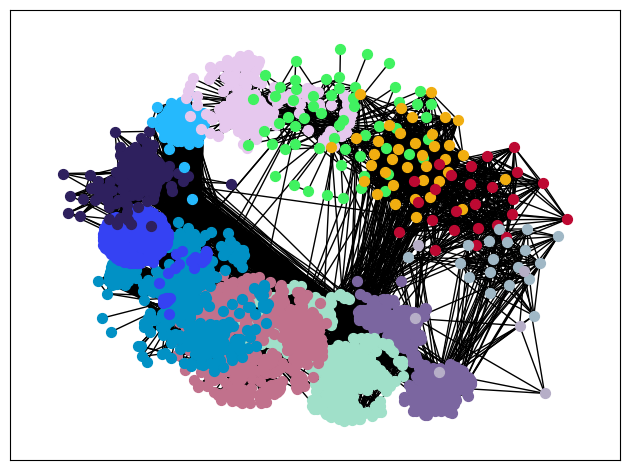

In [101]:
# Visuallize Facebook network communities
def generate_n_random_hex_colors(n):
    """
    Generates a list of N random hexadecimal color codes.
    Each color is represented as a string in the format '#RRGGBB'.
    """
    colors = []
    for _ in range(n):
        # Generate a random integer between 0 and 0xFFFFFF (inclusive)
        # and format it as a 6-digit hexadecimal string.
        hex_color = '#%06x' % random.randint(0, 0xFFFFFF)
        colors.append(hex_color)
    return colors

colors = generate_n_random_hex_colors(len(communities))

communities = nx.community.greedy_modularity_communities(G_fb)

# Compute positions for the node clusters as if they were themselves nodes in a
# supergraph using a larger scale factor
supergraph = nx.cycle_graph(len(communities))
superpos = nx.spring_layout(supergraph, scale=2, seed=429)

# Use the "supernode" positions as the center of each node cluster
centers = list(superpos.values())
pos = {}
for center, comm in zip(centers, communities):
    pos.update(nx.spring_layout(nx.subgraph(G_fb, comm), center=center, seed=1430))

# Nodes colored by cluster
for nodes, clr in zip(communities, generate_n_random_hex_colors(len(communities))):
    nx.draw_networkx_nodes(G_fb, pos=pos, nodelist=nodes, node_color=clr, node_size=50)
nx.draw_networkx_edges(G_fb, pos=pos)

plt.tight_layout()
plt.show()

## B2 – Quantitative Comparison and Summary (5 pts)

Use the results from B1 to create the following **comparative metrics and visuals**:

1. **Summary Table**

In [102]:
tabs = []
headers = ["Network", "Avg Community Size", "Avg Clustering (C)"]

for name, network in networks.items():
    tab = []
    tab.append(name)

    communities = nx.community.greedy_modularity_communities(network)
    tab.append(
        sum(len(community) for community in communities)/len(communities)
    )
    
    tab.append(nx.average_clustering(network))
    tabs.append(tab)

print(tabulate(tabs, headers))
    

Network      Avg Community Size    Avg Clustering (C)
---------  --------------------  --------------------
ER                      807.8               0.0108767
WS                      807.8               0.484933
BA                      149.593             0.0126924
Facebook                310.692             0.605547
